In [59]:
## Evalutate the effect of Zero phase in network inversion
## Test data: SenDT128

import os
import numpy as np
from matplotlib import ticker, pyplot as plt, gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pysar.objects import timeseries, ifgramStack, geometry, sensor
from pysar.utils import plot as pp, network as pnet, ptime
from pysar.simulation import simulation as sim
from pysar.simulation.plot import *
from pysar import ifgram_inversion as ifginv


re_generate_noise = True
lin_velocity = False
display = True


work_dir = '/Users/yunjunz/development/python/2018_ComputGeosci_PySAR/networkInv_zeroPhase'
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
os.chdir(work_dir)
print('Go to directory: '+work_dir)

ref_dir = '/Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR'
ref_dir = '/Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR'
pts_yx = [290, 415]
sensorName = sensor.project_name2sensor_name(ref_dir)[0]

def plot_invert_timeseries(ax, data_list, label_list, ylim=None):
    ax.plot(dates, list(data_list[0]*100.0),
            '--', lw=3, label=label_list[0], color=pp.mplColors[0])
    for data, label, i in zip(data_list[1:],
                              label_list[1:],
                              range(1, len(data_list))):
        ax.scatter(dates, list(data*100.0),
                   s=(marker_size/i)**2, label=label, color=pp.mplColors[i])
    pp.auto_adjust_xaxis_date(ax, datevector, fontsize=12, every_year=1)
    ax.set_xlabel('Time (years)', fontsize=font_size)
    ax.set_ylabel('LOS Displacement (cm)', fontsize=font_size)
    #ax.yaxis.set_label_position("right")
    #ax.yaxis.tick_right()
    if ylim is not None:
        ax.set_ylim(ylim)
    handles, labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[2], handles[0]]
    labels = [labels[1], labels[2], labels[0]]
    ax.legend(handles, labels, loc="upper left", frameon=False, fontsize=font_size)
    return ax

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/networkInv_zeroPhase


open timeseries file: timeseries.h5
write baseline list info to file: bl_list.txt
save range change time series to file.


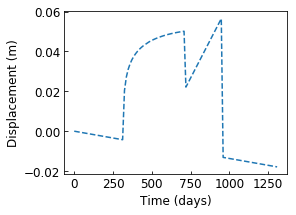

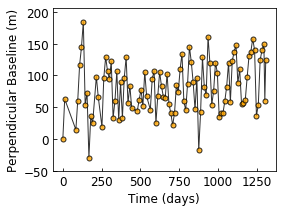

Done.


In [7]:
## 1. Simulate timeseries

ref_ts_file = os.path.join(ref_dir, 'timeseries.h5')
ts_obj = timeseries(ref_ts_file)
ts_obj.open()
date_list = ts_obj.get_date_list()
pbase_list = ts_obj.pbase.tolist()
tbase_list = ts_obj.tbase.tolist()
tbase_diff = np.diff(np.array(ptime.date_list2tbase(date_list)[0], np.float32) / 365.25).reshape(-1, 1)
dates, datevector = ptime.date_list2vector(date_list)
tbase = np.array(ts_obj.tbase)

ts_obj.save2bl_list_file(out_file='bl_list.txt')

TS_TXT_FILE = 'timeseries'
if lin_velocity:
    # Opt 1 - Linear velocity
    ts_sim = sim.velocity2timeseries(date_list, vel=0.01, display=False)
else:
    # Opt 2 - Time variable
    ts_sim = np.zeros(tbase.shape, np.float32)
    idx1 = 20
    ts_sim[idx1:] = 0.01 * np.log(tbase[idx1:] - tbase[idx1-1])
    idx2 = 50
    ts_sim[idx2:] = 0.03 + 0.06 * (tbase[idx2:] - tbase[idx2-1]) / 365.25
    idx3 = 70
    ts_sim[idx3:] = 0.
    ts_sim += tbase * -0.005 / 365.25

np.save(TS_TXT_FILE, np.hstack((np.array(date_list).reshape(-1,1), ts_sim.reshape(-1,1))))
print('save range change time series to file.')


if display:
    fig, ax = plt.subplots(figsize=[4, 3])
    ax.plot(tbase, ts_sim, '--')
    ax.set_xlabel('Time (days)', fontsize=font_size)
    ax.set_ylabel('Displacement (m)', fontsize=font_size)
    ax.tick_params(direction='in', labelsize=font_size)
    #plt.savefig('SimTimeseriesLin'+fig_ext, bbox_inches='tight', dpi=fig_dpi)
    
    fig, ax = plt.subplots(figsize=[4, 3])
    ax.plot(tbase_list, pbase_list, '-ko', alpha=0.8, lw=1, ms=marker_size, mfc='orange')
    ax = pp.auto_adjust_yaxis(ax, pbase_list, font_size)
    ax.set_xlabel('Time (days)',fontsize=font_size)
    ax.set_ylabel('Perpendicular Baseline (m)',fontsize=font_size)
    ax.tick_params(direction='in', labelsize=font_size)
    plt.show()
print('Done.')

open ifgramStack file: ifgramStack.h5
reading incidenceAngle data from file: /Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR/INPUTS/geometryRadar.h5 ...
reading coherence data from file: /Users/yunjunz/insarlab/PYSAR_EXAMPLE/AlcedoSenDT128/PYSAR/INPUTS/ifgramStack.h5 ...


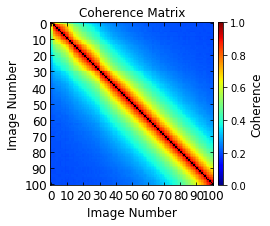

simulate unwrapped phase


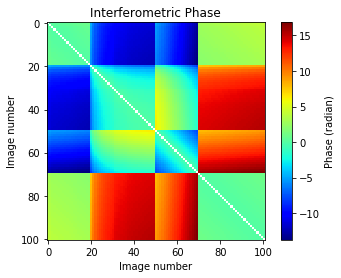

simulate decorrelation noise ...


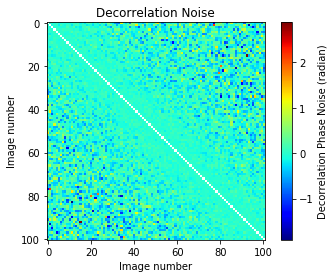

Done.


In [13]:
# Read coherence/date12_list from reference file
stack_obj = ifgramStack(os.path.join(ref_dir, 'INPUTS/ifgramStack.h5'))
stack_obj.open()
geom_obj = geometry(os.path.join(ref_dir, 'INPUTS/geometryRadar.h5'))
inc_angle = np.nanmean(geom_obj.read(datasetName='incidenceAngle'))

date12_list = stack_obj.date12List                # use pairs from data file
date12_list = pnet.select_pairs_all(date_list)    # use all pairs for demonstration
date12_list = ptime.yyyymmdd_date12(date12_list)

box = (pts_yx[1], pts_yx[0], pts_yx[1]+1, pts_yx[0]+1)
coh = stack_obj.read(datasetName='coherence', box=box)

coh = pnet.simulate_coherence(date12_list,
                              baseline_file='bl_list.txt',
                              sensor_name=sensorName,
                              inc_angle=inc_angle,
                              decor_time=200.0,
                              coh_resid=0.2)

# Simulate coherence/date12_list
if display:
    fig, ax = plt.subplots(figsize=[4, 3])
    ax = pp.plot_coherence_matrix(ax, date12_list, coh.flatten().tolist())
    plt.show()

print('simulate unwrapped phase')
wvl = sensor.wavelength('Sen')
phase2range = -1. * wvl / (4. * np.pi)
ifgram_sim = sim.timeseries2ifgram(ts_sim, date_list, date12_list, wvl=wvl, display=display)

print('simulate decorrelation noise ...')
L = int(stack_obj.metadata['ALOOKS']) * int(stack_obj.metadata['RLOOKS'])
decor_noise_file = 'decor_noise.npy'
if re_generate_noise or not os.path.isfile(decor_noise_file):
    decor_sim = sim.simulate_decorrelation_noises(date12_list, coh, L=L, display=display)
    np.save(decor_noise_file, decor_sim)
else:
    decor_sim = np.load(decor_noise_file)

# ifgram with decor noise
ifgram_comb = ifgram_sim + decor_sim
min_coh = 0.4
if min_coh != 0.:
    ifgram_comb[coh<min_coh] = 0.
print('Done.')

In [14]:
## Invert network of ifgrams into time-series
print('Inverting timeseries ...')
A, B = stack_obj.get_design_matrix4timeseries_estimation(date12_list=date12_list)
weight = ifginv.coherence2fisher_info_index(coh, L)

ts_inv = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram_comb,
                                    weight_sqrt=np.sqrt(weight),
                                    skip_zero_phase=True)[0] * phase2range

ts_inv_noskip = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram_comb,
                                           weight_sqrt=np.sqrt(weight),
                                           skip_zero_phase=False)[0] * phase2range

ts0 = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram_sim,
                                 weight_sqrt=np.sqrt(weight),
                                 skip_zero_phase=True)[0] * phase2range

print('Done.')

Inverting timeseries ...
Done.


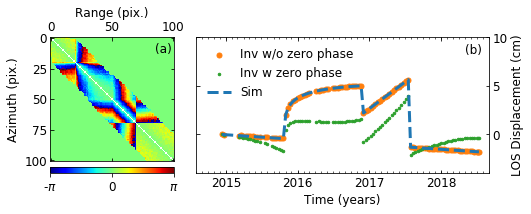

In [60]:
# plot ifgram simulation process
#fig, [ax11, ax12] = plt.subplots(nrows=1, ncols=2, figsize=[8, 3])
fig = plt.figure(figsize=[8, 2.5])
gs = gridspec.GridSpec(nrows=1, ncols=3, figure=fig, hspace=0.1, wspace=0.1)
ax11 = plt.subplot(gs[0, 0])
ax12 = plt.subplot(gs[0, 1:3])

# plot ifgram simulation
data_mat = pnet.coherence_matrix(date12_list, ifgram_comb)
data_mat -= np.round(data_mat/(2*np.pi)) * (2*np.pi)
im = ax11.imshow(data_mat, cmap='jet', vmin=-np.pi, vmax=np.pi)
ax11.set_ylabel('Azimuth (pix.)', fontsize=font_size)
ax11.set_xlabel('Range (pix.)', fontsize=font_size)
ax11.xaxis.tick_top()
ax11.xaxis.set_label_position('top') 

# plot displacement time-series
ax12 = plot_invert_timeseries(ax12,
                              data_list=[ts_sim, ts_inv, ts_inv_noskip],
                              label_list=['Sim',
                                          'Inv w/o zero phase',
                                          'Inv w zero phase'],
                              ylim=[-4, 10])   #
ax12.yaxis.tick_right()
ax12.yaxis.set_label_position("right")
# setup axis format
for ax in [ax11, ax12]:
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

# colorbars
divider = make_axes_locatable(ax11)
cax = divider.append_axes("bottom", "5%", pad="5%")
cbar = plt.colorbar(im, cax=cax, ticks=[-np.pi, 0, np.pi], orientation='horizontal')
cbar.ax.set_xticklabels([r'-$\pi$', '0', r'$\pi$'], fontsize=font_size)

ax11.annotate('(a)', xy=(0.85, 0.88), color='k', xycoords='axes fraction', fontsize=font_size)
ax12.annotate('(b)', xy=(0.92, 0.88), color='k', xycoords='axes fraction', fontsize=font_size)

plt.savefig('networkInv_zeroPhase.jpg', bbox_inches='tight', dpi=fig_dpi)
plt.show()